In [1]:
# set up paths
from os import pardir, getcwd
from os.path import join, abspath
import sys
nb_dir = getcwd()
project_path = abspath(join(nb_dir, pardir))
sys.path.append(project_path)
# 3rd party imports
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import read_pickle, DataFrame
from tqdm import tqdm
# local imports
from pmi_examples.helpers import create_all_card_view_quiz_tasks
from managers.card_view_quiz_manager import CardViewQuizManager
from paths.files import FN_INTERIM_QUIZ, FN_INTERIM_CARD_VIEW_QUIZ

## Investigation of Hypotheses

We have a feeling that the amount of time that people spend reading cards has some relation to their performance on the quiz cards. If we can show this to be true, then this would enable useful interventions, such as recommending the User to take their time scrolling through if they are going too fast. This notebook shows how we might go about investigating this hypothesis.

This time we are using a slightly different implementation of the Database Manager. This one just points to a database that also contains actions of Quiz taking events, along with whether or not the User answered the quiz question correctly. Special case situtations like these are not very difficult to deal with - they typically, involve overriding a couple of methods from the main Database manager, and adding some additional data to the `extra` dict of the relevant `ActionSequence`s and `UserAction`s.

In [2]:
# set up db manager
db = CardViewQuizManager(data=FN_INTERIM_CARD_VIEW_QUIZ)
quiz_results = read_pickle(FN_INTERIM_QUIZ)
# create tasks
tasks = create_all_card_view_quiz_tasks(db=db)
# read sessions from database
sessions = db.sessions()

Now, while iterating over the sessions we will extract action sequences and get rid of the ones that don't contain a quiz result. For the ones that do contain one or more quiz result, we will split them after the quiz results so that we end up with as many sequences as quiz results.

In [4]:
quiz_sequences = []
for session in tqdm(sessions, 'Scanning Sessions'):
    session_sequence = db.get_session_sequence(session.session_id)
    # ignore sessions without quiz results
    if not session_sequence.extra['has_quiz_result']:
        continue
    # split into sub-sequences that end on quiz results
    quiz_sequences.extend(
        session_sequence.split_after(condition=lambda ua: ua.action_type == 'quiz',
                                     copy_extra=False)
    )

Scanning Sessions: 100%|██████████| 1246/1246 [00:11<00:00, 112.12it/s]


Now we will iterate through the sequences, and extract the information relevant to our hypothesis, i.e. their durations, numbers of actions and whether the User answered correctly or not.

In [5]:
question_results = defaultdict(list)
for sequence in quiz_sequences:
    quiz_action = sequence.user_actions[-1]
    question_id = quiz_action.source_id
    correct = quiz_action.extra['correct']
    question_results[question_id].append({
        'duration': sequence.duration(),
        'num_actions': len(sequence),
        'correct': correct
    })

In [7]:
question_results

defaultdict(list,
            {'/topic/Risk Management/1/23_quiz': [{'duration': Timedelta('0 days 00:00:32.180000'),
               'num_actions': 24,
               'correct': False},
              {'duration': Timedelta('0 days 00:25:56.715000'),
               'num_actions': 32,
               'correct': True},
              {'duration': Timedelta('0 days 00:07:12.567000'),
               'num_actions': 50,
               'correct': True},
              {'duration': Timedelta('0 days 00:05:46.468000'),
               'num_actions': 99,
               'correct': False},
              {'duration': Timedelta('0 days 00:00:12.170000'),
               'num_actions': 5,
               'correct': True},
              {'duration': Timedelta('0 days 00:07:15.694000'),
               'num_actions': 62,
               'correct': True},
              {'duration': Timedelta('0 days 00:36:11.483000'),
               'num_actions': 41,
               'correct': True},
              {'duration': T

Finally, plot the distribution of times for correct and incorrect quiz answers, for each topic:

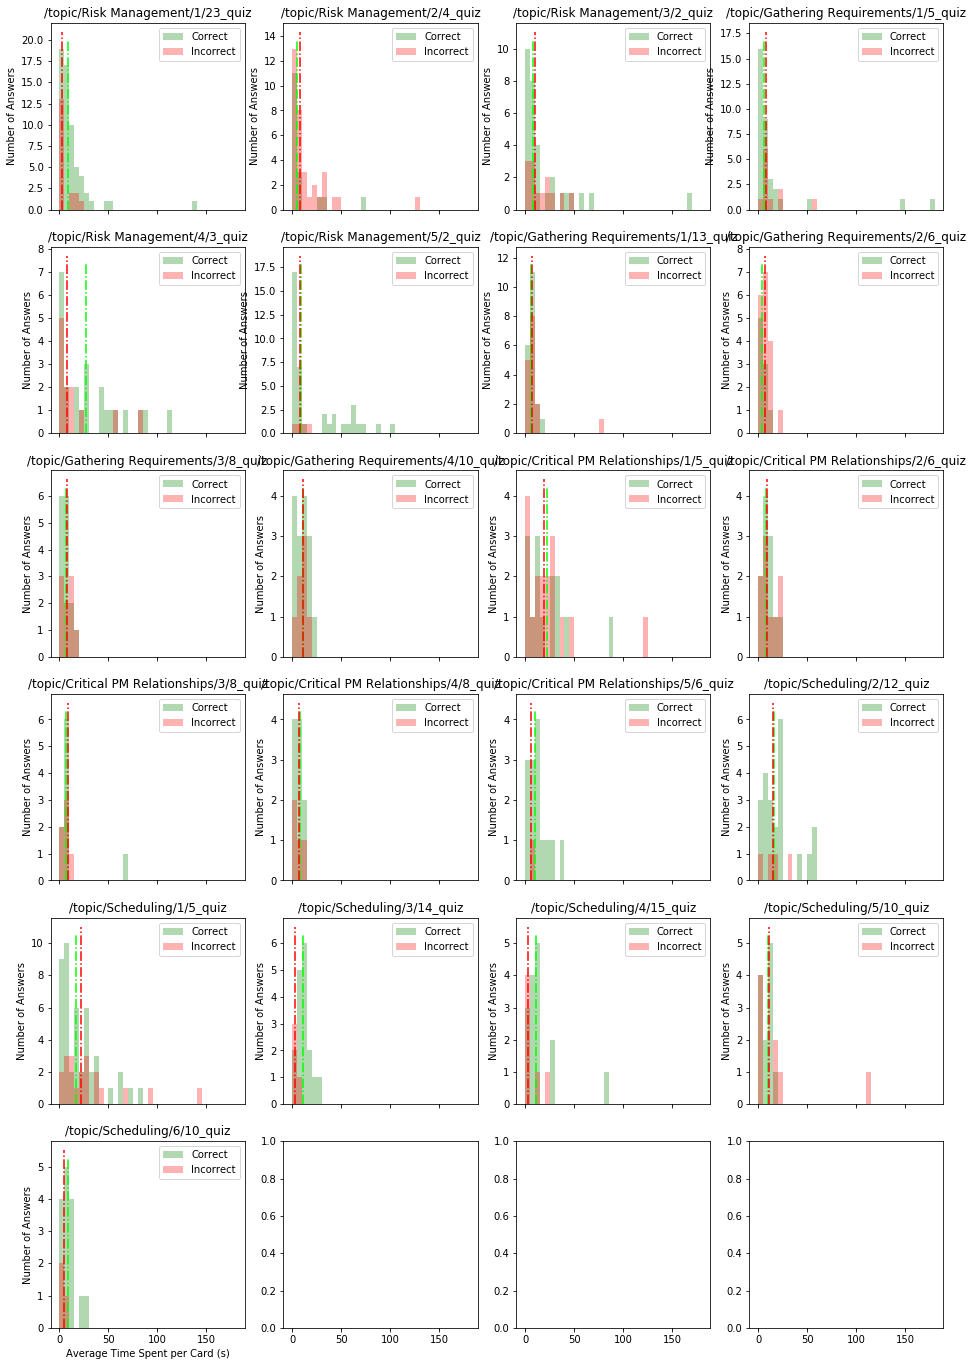

In [8]:
bins = range(0, 181, 5)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16, 24), sharex='all')
i_ax = 0
for question, results in question_results.items():
    question_data = DataFrame(results)
    question_data['average_action_duration'] = (
        question_data['duration'].dt.total_seconds() /
        question_data['num_actions']
    )
    # filter out answers where someone went straight in and answered without reading any cards
    question_data = question_data.loc[question_data['average_action_duration'] > 0]
    if len(question_data) == 0:
        continue
    # plot
    ax = axes.flat[i_ax]
    correct = question_data.loc[question_data['correct'] == True, 'average_action_duration']
    correct.plot(kind='hist', label='Correct', color='green', ax=ax, bins=bins, alpha=0.3)
    incorrect = question_data.loc[question_data['correct'] == False, 'average_action_duration']
    incorrect.plot(kind='hist', label='Incorrect', color='red', ax=ax, bins=bins, alpha=0.3)
    ax.vlines(correct.median(), *ax.get_ylim(), '#00ff00', '-.')
    ax.vlines(incorrect.median(), *ax.get_ylim(), '#ff0000', '-.')
    ax.set_xlabel('Average Time Spent per Card (s)')
    ax.set_ylabel('Number of Answers')
    ax.legend()
    ax.set_title(question)
    i_ax += 1

We can see from the above that our hypothesis may be true for **some** topics, although we will need to go further and conduct some form of significance testing if we want to confirm this. However, for many topics there is either no significant difference in the average times or the evidence appears to contradict our hypothesis. Perhaps the correct results with short times represent users who are attempting the quiz for the second or third time. This could be done with a relatively minor modification of the existing code.